# 머신러닝(Machine Learning)

## KNN(K-Nearest Neighbor) - 손글씨 분류 예제

### 1. 데이터 불러오기

이번 실습부터 새로이 사용하는 라이브러리가 있습니다. 하는 역할에 대해 자세히 기술드릴 예정이며, 그럼에도 이해가 되지 않는다면 질문주시기 바랍니다!

In [1]:
# 사용 라이브러리 불러오기

## numpy: 파이썬에서 사용하는 대표적인 연산 라이브러리로 "행렬" 연산을 가능하게 해줍니다.
import numpy as np
## torch: 딥러닝을 모델을 구축하는데 있어서 핵심이 되는 라이브러리로, numpy와 같은 기능을 하지만, GPU를 이용한 "병렬계산"이 가능한 것이 특징이자 강점입니다.
import torch
## torchvision: 딥러닝에서 유명한 데이터셋(torchvison.datasets)과 모델(torchvision.models), 그리고 이미지 전처리 코드(torchvision.transforms)가 저장되어 있는 라이브러리입니다.
## 여기서 불러오는 데이터셋들은 전처리가 완료된 이미지들이므로, 이번 시간에는 dataset만 불러오도록 하겠습니다.
from torchvision import datasets

In [2]:
# Train 데이터와 Test 데이터를 각각 불러옵니다.
## 이번에 우리가 사용할 데이터는 MNIST로, 미국 우편국에서 수집한 손글씨로 작성된 숫자 이미지 입니다.
trainset = datasets.MNIST ( root = './data', train =True ,download = True )
testset = datasets.MNIST ( root = './data', train =False ,download = True )

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16258701.63it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 549532.71it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4424038.46it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11272502.23it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



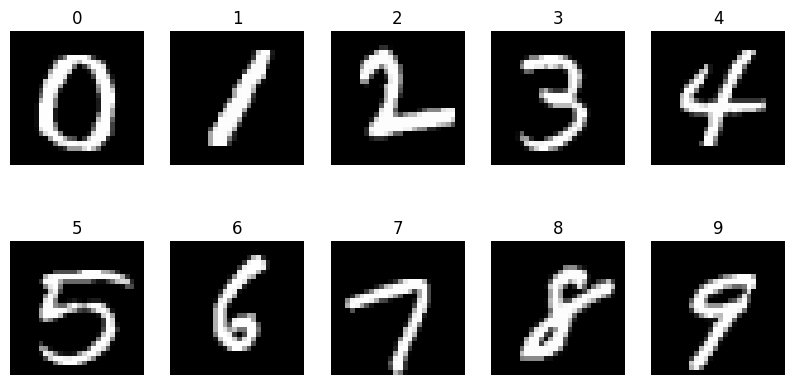

In [3]:
# 시각화 툴을 불러와서 데이터가 어떻게 생겨먹었는지 확인해봅시다!
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 5))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    while label != i-1:
        sample_idx = torch.randint(len(trainset), size=(1,)).item()
        img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(str(i-1))
    plt.axis("off")
    plt.imshow(img, cmap='gray')
plt.show()

뭔가 좀 징그러운 것 같기도 하고... 아무튼 이렇게 생겼다고 하네요

### 2. Train data를 Train data와 Validation data로 분할

In [4]:
# 잠깐! 우리가 잊지 말고 해야하는 일 중에 Random seed를 고정하는 것이 있습니다.
# python 실력이 수준급인 여러분은 random seed가 어떤 역할을 하는지 알고 있다고 생각하고 진행하겠습니다.

## seed 고정
np.random.seed(0)

In [5]:
# train 데이터의 이미지 개수 확인
train_size = len(trainset)
print(train_size)

60000


In [6]:
# train 데이터의 이미지 인덱스를 리스트로 저장 -> 리스트에 있는 인덱스의 일정 비율을 validation으로 사용할 예정
indices = list(range(train_size))
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [7]:
# train 데이터를 9:1로 나누어 각각 train과 validation으로 사용합시다.
val_ratio = 0.1

# np.floor는 math.floor와 동일한 함수로, 내림하는 함수입니다.
## 아래 코드를 통해서 몇번 인덱스에서 데이터를 나눌지 구합시다.
split_idx = int(np.floor(val_ratio*train_size))
print(split_idx)

6000


여기서 잠깐, 여러분 저희 첫 수업에서 데이터를 shuffle 하지 않고 학습했을 때 학습 성능이 떨어지는 결과가 나왔던 것을 기억하시나요?

In [8]:
# 이번에는 똑같은 실수를 하지 않도록 잘 섞어줍시다.
np.random.shuffle(indices)

In [9]:
# 슬라이싱을 사용하여 데이터를 두개로 나누어줍시다! 이정도는 쉽죠?
train_idx, val_idx = indices[split_idx:], indices[:split_idx]

# train data의 개수와 인덱스 확인
print("train_idx size:", len(train_idx))
print("train_idx:", train_idx)

# validation data의 개수와 인덱스 확인
print("val_idx size:", len(val_idx))
print("val_idx:", val_idx)

train_idx size: 54000
train_idx: [50234, 22686, 31748, 11359, 32533, 14648, 18590, 40216, 13178, 19962, 5653, 58486, 14125, 38261, 53041, 14634, 18232, 18569, 37523, 30806, 20562, 21995, 16719, 50756, 13118, 49887, 57291, 17266, 30945, 2412, 9891, 41716, 47620, 58334, 34225, 1788, 39582, 37576, 23683, 5450, 18438, 9014, 59815, 24313, 13965, 30715, 55937, 5442, 41973, 11087, 33883, 21620, 10629, 26329, 43964, 42564, 55024, 22805, 2480, 37489, 37912, 35203, 38773, 54741, 23219, 913, 51934, 2411, 29381, 8047, 1964, 58263, 51042, 27244, 13582, 7702, 25249, 37393, 42546, 10700, 1560, 54749, 55574, 21670, 35934, 23364, 47008, 779, 40706, 40348, 10123, 26189, 55240, 21085, 32135, 3686, 45850, 52405, 377, 7066, 24656, 991, 44184, 46196, 45063, 33890, 4111, 56161, 57997, 31675, 4131, 16049, 37902, 47003, 22740, 1066, 41181, 1872, 54063, 15187, 14821, 31116, 23113, 53000, 11285, 59334, 16669, 12209, 44698, 33776, 18154, 7107, 16437, 22134, 10826, 5187, 45923, 32829, 44232, 639, 41877, 56804, 549

In [10]:
# trainset.data는 이미지를 데이터로 바꾼 것을 의미합니다. 우리 하나만 꺼내서 모습을 확인해볼까요?
# .shape를 사용하면 이미지의 크기를 확인할 수 있고(28x28) .shape를 제거하면 데이터셋이 어떻게 생겼는지 확인할 수 있습니다.
trainset.data[0].shape

torch.Size([28, 28])

In [11]:
# 이미지는 28x28의 크기를 가지며, 각 픽셀은 0부터 255의 값을 가집니다.
# 이유는 RGB가 0~255 사이이기 때문이죠.
# 이 이미지는 1x28x28로 gray scale이긴 하지만, 숫자가 적힌 부분은 밝은, 즉 255에 가까운 값을 가집니다.
# 하지만, 수가 커지면 계산은 복잡해지니까 255로 나누어 0과 1사이의 분포를 가지도록 데이터를 수정해줍시다.

train_data = trainset.data[train_idx].float()/255.
train_labels = trainset.targets[train_idx]

val_data = trainset.data[val_idx].float()/255.
val_labels = trainset.targets[val_idx]

test_data = testset.data.float()/255.
test_labels = testset.targets

### 3. GPU(CUDA)와 CPU 비교

In [12]:
# 비교를 위해서 GPU를 사용하는 방법에 대해 알려드리겠습니다.
# GPU를 사용하는 코드는 다음과 같습니다.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device: {device}')

device: cuda


In [13]:
# 만약 위 코드의 결과가 device: cuda가 나오지 않는 분들은 우측 상단에 있는 '연결'에서 런타임 유형을 T4로 변경해주세요.

# 우리가 GPU를 사용하기 위해서는 데이터와 모델을 GPU 위로 옮겨야하는데요, 일단 먼저 데이터를 먼저 옮겨줍시다.
## 옮기는 코드는 .to(device) 또는 device='cuda' 설정을 하지 않았다면 .to('cuda')도 괜찮습니다.
if device == 'cuda':
    train_data, train_labels = train_data.to(device), train_labels.to(device)
    val_data, val_labels = val_data.to(device), val_labels.to(device)
    test_data, test_labels = test_data.to(device), test_labels.to(device)
    print("Move dataset to GPU successfully.")
else:
    print("GPU device is not available.")

Move dataset to GPU successfully.


In [14]:
# CPU와 GPU를 비교하기 위해 time 라이브러리를 불러오겠습니다.
import time

In [15]:
# 우리가 오늘 수업에서 배운 유클리드 거리를 나타내는 코드입니다. 어렵지 않아요
# 코드를 한번 천천히 읽어보시고, 모르는 부분은 질문을 주시면 됩니다.
def Euclidean_Distance(k, x, y, test):
    x = torch.flatten(x, 1)
    test = torch.flatten(test.unsqueeze(dim=0), 1)
    distances = []
    for idx in range(len(x)):
        distance = torch.sum(((x[idx]-test)**2), dim=1)
        distances.append(distance)
    _, distance_idx = torch.topk(input=torch.tensor(distances), k=k, largest=False)
    labels = y[distance_idx]
    return Mode(labels)

# 유클리드 거리에서 구한 k개의 데이터 label 중 가장 많은 label을 알려줍니다.
def Mode(numbers):
    return torch.mode(numbers).values.item()

# 일단은 하나의 test case에 대해서만 진행하면 되므로 랜덤한 test 인덱스를 넣어 성능을 확인해봅시다.
k = 5
x = train_data
y = train_labels
idx = np.random.randint(0, 9999)
test = test_data[idx]

start = time.time()

predict = Euclidean_Distance(k, x.to('cpu'), y.to('cpu'), test.to('cpu'))
label = test_labels[idx]

end = time.time()

print('CPU -----------------------')
print(f'label: {label}\nresult: {predict}')
print(f'Time: {(end-start):.3f}')
print('---------------------------')

start = time.time()

predict = Euclidean_Distance(k, x.to(device), y.to(device), test.to(device))
label = test_labels[idx]

end = time.time()

print('GPU(CUDA) -----------------')
print(f'label: {label}\nresult: {predict}')
print(f'Time: {(end-start):.3f}')
print('---------------------------')

CPU -----------------------
label: 8
result: 8
Time: 2.343
---------------------------
GPU(CUDA) -----------------
label: 8
result: 8
Time: 2.903
---------------------------


어라.. 왜 GPU가 더 느리지.. 이상합니다

In [16]:
# 제가 코드를 살짝 바꾸어보았는데, 한번 실행해봅시다.

def Euclidean_Distance(k, x, y, test):
    x = torch.flatten(x, 1)
    test = torch.flatten(test.unsqueeze(dim=0), 1)
    distance = torch.sum(((x-test)**2), dim=1)
    _, distance_idx = torch.topk(input=distance, k=k, largest=False)
    labels = y[distance_idx]
    return Mode(labels)

def Mode(numbers):
    return torch.mode(numbers).values.item()

k = 5
x = train_data
y = train_labels
idx = np.random.randint(0, 9999)
test = test_data[idx]

start = time.time()

predict = Euclidean_Distance(k, x.to('cpu'), y.to('cpu'), test.to('cpu'))
label = test_labels[idx]

end = time.time()

print('CPU -----------------------')
print(f'label: {label}\nresult: {predict}')
print(f'Time: {(end-start):.3f}')
print('---------------------------')

start = time.time()

predict = Euclidean_Distance(k, x.to(device), y.to(device), test.to(device))
label = test_labels[idx]

end = time.time()

print('GPU(CUDA) -----------------')
print(f'label: {label}\nresult: {predict}')
print(f'Time: {(end-start):.3f}')
print('---------------------------')

CPU -----------------------
label: 3
result: 3
Time: 0.354
---------------------------
GPU(CUDA) -----------------
label: 3
result: 3
Time: 0.100
---------------------------


얼레 이번에는 GPU가 월등히 빠르네요? 그 이유가 뭘까요? 제가 함수의 어느 부분을 수정했는지 한번 맞춰보시겠어요?

In [17]:
# 이번에는 위의 정보를 이용해서 KNN을 구현해보았습니다.
class KNN():
    ALGORITHM = {'Euclide':'Euclidean Distance'}
    def __init__(self, k=5, algorithm='Euclide'):
        self.k = k
        if algorithm in KNN.ALGORITHM:
            self.algorithm = algorithm
            self.algorithm_name = KNN.ALGORITHM[algorithm]
        else:
            raise Exception(f'There is no \'{algorithm}\' algorithm')

    def fit(self, x, y):
        self.x = x
        self.y = y

    def Euclidean_Distance(self, test):
        test = test.unsqueeze(dim=0)
        distance = torch.sum((self.x-test)**2, dim=1)
        _, distance_idx = torch.topk(input=distance, k=self.k, largest=False)
        labels = self.y[distance_idx]
        return self.Mode(labels)

    def Mode(self, numbers):
        return torch.mode(numbers).values.item()

    def predict(self, tests):
        numlst = []
        self.x = torch.flatten(self.x, 1)
        tests = torch.flatten(tests, 1)
        if self.algorithm == 'Euclide':
            for idx in range(len(tests)):
                number = self.Euclidean_Distance(tests[idx])
                numlst.append(number)
        return torch.tensor(numlst)

    def accuracy(self, labels, pred):
        accuracy = 0
        for idx in range(len(labels)):
            accuracy += 1 if labels[idx] == pred[idx] else 0
        accuracy = accuracy/len(labels)
        return round(accuracy*100, 2)

In [18]:
# 여기서 KNN class를 불러옵니다. KNN class의 hyperparameter인 k를 수정하여 성능을 조절해보세요!
knn = KNN()
print(f'K-Nearest Neighbors (k={knn.k}, {knn.algorithm_name})\n')

knn.fit(train_data, train_labels)

start = time.time()

pred_val = knn.predict(val_data)
acc_val = knn.accuracy(val_labels, pred_val)

end = time.time()

print(f'Validation Accuracy : {acc_val}%\nValidation Time : {(end-start):.1f} second(s)\n')

start = time.time()

pred_test = knn.predict(test_data)
acc_test = knn.accuracy(test_labels, pred_test)

end = time.time()

print(f'Test Accuracy : {acc_test}%\nTest Time : {(end-start):.1f} second(s)')

K-Nearest Neighbors (k=5, Euclidean Distance)

Validation Accuracy : 97.37%
Validation Time : 22.3 second(s)

Test Accuracy : 96.65%
Test Time : 37.1 second(s)


이렇게 우리는 KNN을 구현하는데 성공했습니다. 사실 KNN보다 이번 수업에서 알아가셔야하는건 CUDA인데요, 지금의 AI 및 딥러닝 기술이 있는데는 이 CUDA의 공이 큽니다.

또한, KNN에서 k의 수나 거리를 측정하는 식 같은 경우에는 hyperparameter라고 하며, 이것을 어떻게 조절하느냐에 따라 모델의 성능이 크게 차이가 납니다.

이 코드의 아래에 유클리드 거리 말고 사용할 수 있는 다양한 식을 포함한 식을 넣어놓겠습니다. 여러분은 이것저것 해보시고 질문점에 대해서 질문 주세요!

In [23]:
import torch.nn.functional as F

class KNN():
    ALGORITHM = {'Euclide':'Euclidean Distance', 'Manhattan':'Manhattan Distance', 'Cosine':'Cosine Similarity'}
    def __init__(self, k=5, algorithm='Euclide', Distance='norm'):
        self.k = k
        self.Distance = Distance
        if algorithm in KNN.ALGORITHM:
            self.algorithm = algorithm
            self.algorithm_name = KNN.ALGORITHM[algorithm]
        else:
            raise Exception(f'There is no \'{algorithm}\' algorithm')

    def fit(self, x, y):
        self.x = x
        self.y = y

    def Euclidean_Distance(self, test):
        test = test.unsqueeze(dim=0)
        if self.Distance == 'pairwise':
            distance = F.pairwise_distance(self.x, test)
        elif self.Distance == 'norm':
            distance = torch.norm(self.x - test, dim=1)
        elif self.Distance == 'cdist':
            distance = torch.cdist(self.x, test, p=2).squeeze()
        _, distance_idx = torch.topk(input=distance, k=self.k, largest=False)
        labels = self.y[distance_idx]
        return self.Mode(labels)

    def Manhattan_Distance(self, test):
        test = test.unsqueeze(dim=0)
        if self.Distance == 'pairwise':
            distance = F.pairwise_distance(self.x, test, p=1)
        elif self.Distance == 'norm':
            distance = torch.norm(self.x - test, p=1, dim=1)
        elif self.Distance == 'cdist':
            distance = torch.cdist(self.x, test, p=1).squeeze()
        _, distance_idx = torch.topk(input=distance, k=self.k, largest=False)
        labels = self.y[distance_idx]
        return self.Mode(labels)

    def Cosine_Similarity(self, test):
        test = test.unsqueeze(dim=0)
        _, similarity_idx = torch.topk(input=F.cosine_similarity(self.x, test), k=self.k, largest=True)
        labels = self.y[similarity_idx]
        return self.Mode(labels)

    def Mode(self, numbers):
        return torch.mode(numbers).values.item()

    def predict(self, tests):
        numlst = []
        self.x = self.x.reshape([self.x.size(0), 784])
        tests = tests.reshape([tests.size(0), 784])
        if self.algorithm == 'Euclide':
            for idx in range(len(tests)):
                number = self.Euclidean_Distance(tests[idx])
                numlst.append(number)
        elif self.algorithm == 'Manhattan':
            for idx in range(len(tests)):
                number = self.Manhattan_Distance(tests[idx])
                numlst.append(number)
        elif self.algorithm == 'Cosine':
            for idx in range(len(tests)):
                number = self.Cosine_Similarity(tests[idx])
                numlst.append(number)
        return torch.tensor(numlst)

    def accuracy(self, labels, pred):
        accuracy = 0
        for idx in range(len(labels)):
            accuracy += 1 if labels[idx] == pred[idx] else 0
        accuracy = accuracy/len(labels)
        return round(accuracy*100, 2)

In [24]:
knn = KNN(k=5, algorithm='Manhattan')

print(f'K-Nearest Neighbors ({knn.algorithm_name})\n')

knn.fit(train_data, train_labels)

start = time.time()

pred_val = knn.predict(val_data)
acc_val = knn.accuracy(val_labels, pred_val)

end = time.time()

print(f'<Calculation method - {knn.Distance}>')
print(f'Validation Accuracy : {acc_val}%\nValidation Time : {(end-start):.1f} second(s)\n')

K-Nearest Neighbors (Manhattan Distance)

<Calculation method - norm>
Validation Accuracy : 96.55%
Validation Time : 13.7 second(s)



### 4. 결과 확인 (Test data)

우리는 지금까지 validation data를 사용하여 성능을 지속적으로 체크했는데요, validation에서 가장 좋았던 조건을 사용하여 test data에 대해 성능을 확인해보면 됩니다.

In [26]:
knn = KNN(k=5, algorithm='Euclide')

print(f'K-Nearest Neighbors ({knn.algorithm_name})\n')

knn.fit(train_data, train_labels)

start = time.time()

pred_test = knn.predict(test_data)
acc_test = knn.accuracy(test_labels, pred_test)

end = time.time()

print(f'<Calculation method - {knn.Distance}>')
print(f'Validation Accuracy : {acc_test}%\nValidation Time : {(end-start):.1f} second(s)\n')

K-Nearest Neighbors (Euclidean Distance)

<Calculation method - norm>
Validation Accuracy : 96.65%
Validation Time : 22.8 second(s)

